<a href="https://colab.research.google.com/github/RamiroVelascoM/SDC-Proyecto/blob/main/ProyectoSDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 2.8 MB/s eta 0:00:00


Polo 1 de Gp: (-8104.796142130928+0j)
Polo 2 de Gp: (-1895.228276656557+0j)
Polo 1 de Gcl: (-7975.560341702712+0j)
Polo 2 de Gcl: (-2024.4640770847723+0j)
Omega: (4018.2378484105543+0j)
sita: (1.2443295787907471+0j)


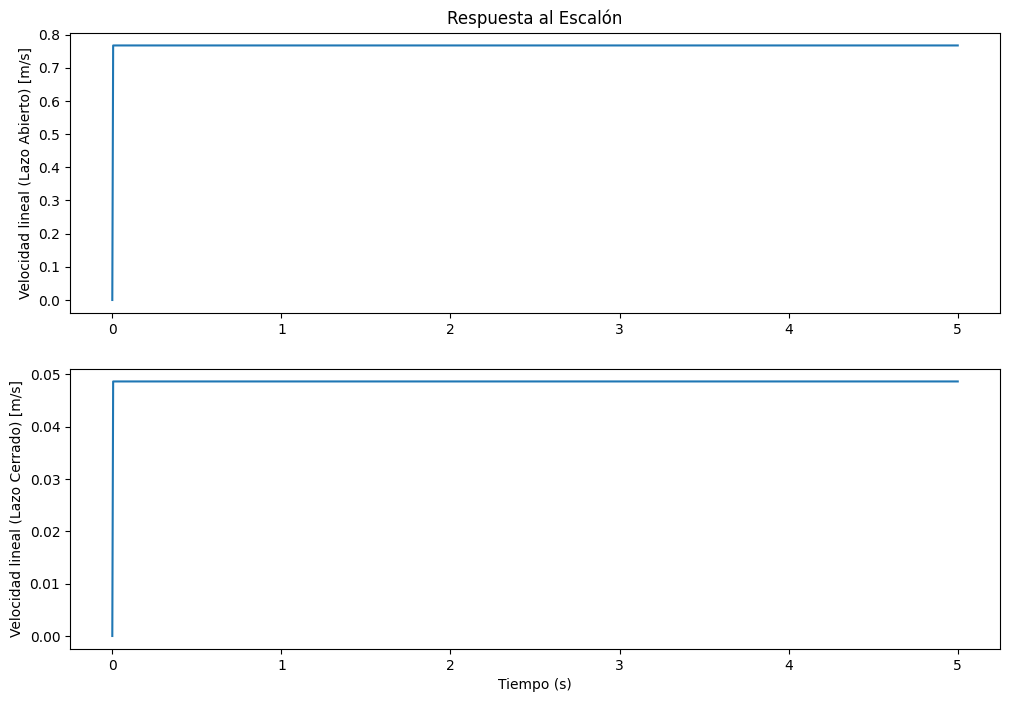

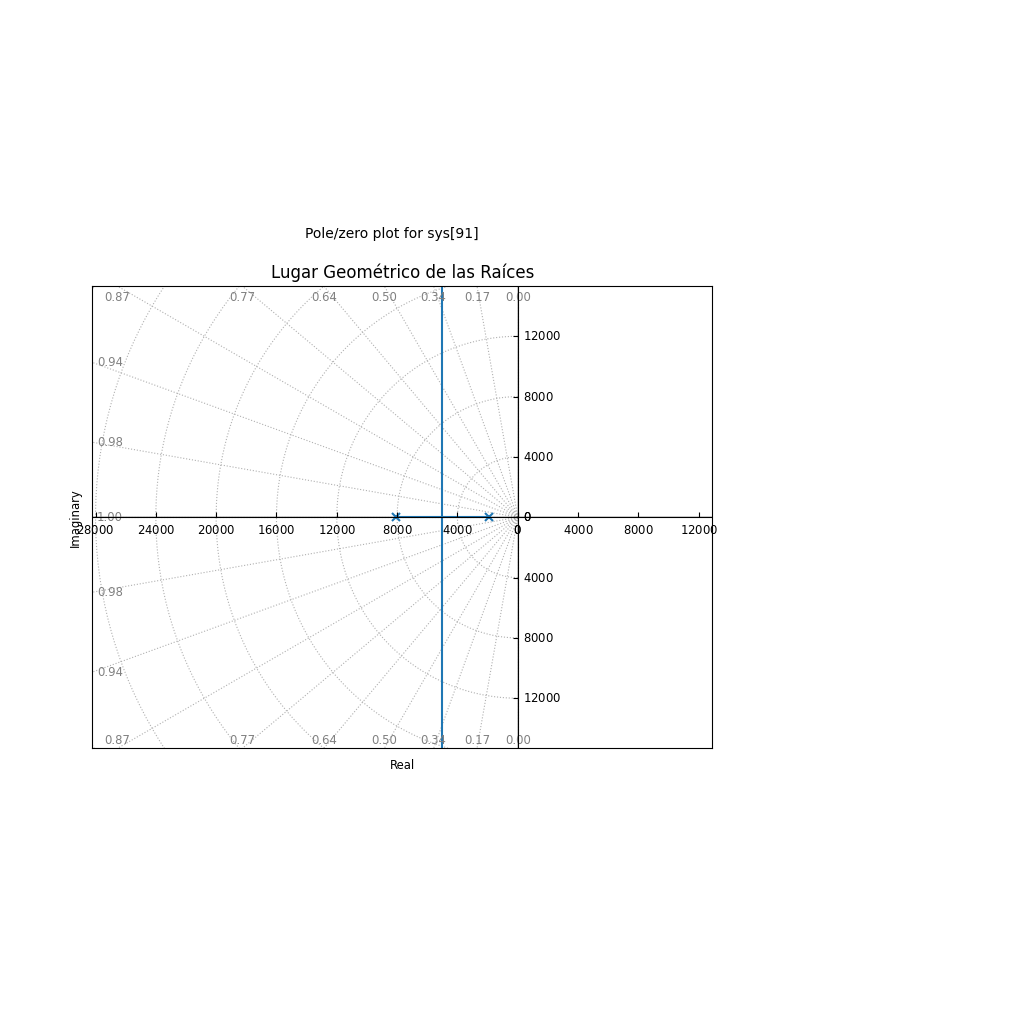

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import math
from scipy.optimize import minimize

# Parámetros del motor en SI
R = 0.628                # Ohm                 --> R   = resistencia en bornes
L = 0.10 * (10**(-3))    # mH a H              --> L   = inductancia en bornes
Jm = 60.2 * (10**(-7))   # g*cm^2 a kg*m^2     --> Jm  = inercia del rotor
B = 10**(-5)             # N*m*rad/s           --> B   = fricción mecánica
k1 = 32.18 * (10**(-3))   # mV*s/rad a V*s/rad  --> k1  = constante de FEM
k2 = 32.18 * (10**(-3))   # mN*m/A a N*m/A      --> k2  = constante de par
n = 1/5                 #                     --> n   = relacion de transmision

# Parámetros de la cinta, rodillos y carga
Radio_Rodillos = 0.06/2                           # m         --> Diametro de cada rodillo (x2)
Masa_Rodillos = 0.35                              # Kg        --> Masa de cada rodillo
Longitud_Cinta = 2 + Radio_Rodillos * math.pi     # m         --> Longitud cinta, ida y vuelta
Ancho_Cinta = 0.2                                 # m         --> Ancho de la cinta
Densidad_Cinta = 2.3                              # Kg/m^2    --> Densidad del material de la cinta
Area_Cinta = Longitud_Cinta*Ancho_Cinta           # m^2       --> Area de la cinta, ida y vuelta
Masa_Cinta = Area_Cinta*Densidad_Cinta            # Kg        --> Masa de la cinta
Carga = 10                                       # Kg        --> Carga en la cinta transportadora

# Calculos sin carga (cinta + rodillos + transmision)
MOI_rollers = (1/4) * Masa_Rodillos * (Radio_Rodillos**2) * 2   # Kg*m^2    --> Momento de inercia de los rodillos (x2)
MOI_object = (Masa_Cinta) * (Radio_Rodillos**2)                 # Kg*m^2    --> Momento de inercia de la cinta
MOI_gearbox = 6.3 * (10**(-5))                                  # Kg*m^2    --> Momento de inercia de la caja de cambios, le cambie 4 por un 5 para que no tenga tanto peso

# Calculos con carga (cinta + rodillos + transmision + carga)
MOI_object = (Masa_Cinta + Carga) * (Radio_Rodillos**2)
MOI_sumatoria = MOI_rollers + MOI_object + MOI_gearbox

# Calculos finales
Jeq = (Jm + (n**2) * MOI_sumatoria)
Beq = 10**(-5)

A = Jeq*L
B = Jeq + (Beq*L)
C = R + (R*Beq) + (k1*k2)
D = k2

# Función de transferencia de la planta
s = ctrl.TransferFunction.s
Gp = D / ((A*s**2) + (B*s) + C)

# Simulación con los parámetros óptimos
# C = ctrl.TransferFunction([Kd_opt, Kp_opt, Ki_opt], [1, 0])
# Gpid = ctrl.feedback(C * Gp, 1)
# Kp = 20  # Ajustar según necesidades
# Ki = 20  # Ajustar según necesidades
# Kd = 1   # Ajustar según necesidades
#T = 3;
#L = 0.1;

#Kp = 0.9 * T/L  # Ajustar según necesidades
#Ki = L/0.3  # Ajustar según necesidades
#Kd = 0   # Ajustar según necesidades
#C = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])

# Sistema en lazo cerrado con controlador PID
#Gpid = ctrl.feedback(C * Gp, 1)

# Obtener los polos de Gp
poles = ctrl.poles(Gp)
print("Polo 1 de Gp:", poles[0])
print("Polo 2 de Gp:", poles[1])

# Tiempos para simular
t = np.linspace(0, 5, 1000)

# Respuesta al escalón en LA
t, y_open_loop = ctrl.step_response(Gp, t)
y_open_loop *= 15

# Otra forma
#A = 18
#u = A * np.ones_like(t)  # Señal de entrada: escalón de magnitud A
#t, y_open_loop, = ctrl.forced_response(Gp, t, u)

# Sistema en lazo cerrado con H(s)=1
Gcl = ctrl.feedback(Gp)
poles = ctrl.poles(Gcl)
print("Polo 1 de Gcl:", poles[0])
print("Polo 2 de Gcl:", poles[1])

# Parametros caracteristicos 2do orden
omega = (poles[0]*poles[1])**(1/2)
sita  = abs(poles[0]+poles[1]) / (2*omega)
print("Omega:", omega)
print("sita:", sita)

# Respuesta al escalón en LC
t, y_closed_loop = ctrl.step_response(Gcl, t)

# Respuesta al escalón PID
#t, y_PID = ctrl.step_response(Gpid, t)

# Respuestas en función del tiempo
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_open_loop)
plt.title('Respuesta al Escalón')
plt.ylabel('Velocidad lineal (Lazo Abierto) [m/s]')

plt.subplot(2, 1, 2)
plt.plot(t, y_closed_loop)
plt.ylabel('Velocidad lineal (Lazo Cerrado) [m/s]')
plt.xlabel('Tiempo (s)')

#plt.subplot(2, 1, 2)
#plt.plot(t, y_PID)
#plt.ylabel('Velocidad lineal (Lazo Cerrado) [m/s]')
#plt.xlabel('Tiempo (s)')

# Gráfica del LGR
plt.figure(figsize=(8, 6))
ctrl.root_locus(Gp, plot=True, grid=True)
plt.title('Lugar Geométrico de las Raíces')

plt.show()